# **RL Homework Tutorial 1**
This notebook contains the homework exercises from tutorial 1 of Deep Reinforcement Learning in AML.

# Homework Overview

## What you'll do in this notebook:

During the tutorial, you implemented the core building blocks of REINFORCE:
- `discounted_return` - Computing rewards-to-go
- `compute_loss` - The REINFORCE loss function  
- `get_policy` - Getting stochastic policies from a neural network

You also already got a quick look at the whole implementation of the algorithm.

Now you'll complete the algorithm by yourself and experiment with it!

---

### Exercise 1: Implement `get_action`
Sample actions from your policy for interacting with the environment.

### Exercise 2: Implement `train_one_epoch`  
Build the main training loop that collects experience and updates the policy.

### Exercise 3: Complete the Training Loop
Fill in the TODOs to set up and run the full training process.

### Exercise 4: Experimentation
Try your algorithm on different environments (CartPole, LunarLander, BipedalWalker)
and experiment with hyperparameters to see how they affect learning!

---

**Note:** This homework includes some very basic test functions similar to the ones you encountered in the in-class exercises. You can also compare your solutions with the mastersolution of the complete REINFORCE algorithm (available on the polybox).

The goal for this homework exercises is to deepen your understanding through hands-on implementation and experimentation.

# Setup - Run these cells first
This section includes the needed imports and the functions already implemented during the in-class exercises.

In [1]:
!pip install swig
!pip install gymnasium[box2d]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from torch.optim import Adam
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Sequence
from tqdm import tqdm

In [3]:
def mlp(sizes: Sequence[int], activation=nn.ReLU, output_activation=nn.Identity) -> nn.Sequential:
  """
  Create a simple feedforward neural network.
  """
  layers = []
  for j in range(len(sizes)-1):
    act = activation if j < len(sizes)-2 else output_activation
    layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
  return nn.Sequential(*layers)

In [ ]:
def get_policy(obs: torch.Tensor) -> Normal:
  """
  Get the stochastic policy for a given observation (-batch).
  Returns a distribution for every action.
  """
  obs = obs.unsqueeze(0) if obs.dim() == 1 else obs  # for single observations that do not have a batch dimension
  logits = policy_net(obs)
  mean, logstd = logits[:, :n_acts], logits[:, n_acts:]  # split the output layer into mean and logstd
  logstd = torch.clamp(logstd, min=-20, max=2)  # for numerical stability
  return Normal(mean, torch.exp(logstd))

In [5]:
def compute_loss(obs: torch.Tensor, act: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
  """
  Compute the REINFORCE loss for a given batch.
  """
  dist = get_policy(obs)
  logp = dist.log_prob(act).sum(dim=-1)
  return -(logp * weights).mean()

In [6]:
def discounted_return(arr: Sequence[float]) -> list[float]:
  """
  Compute the discounted return for a single episode, given a sequence of rewards.
  """
  ret = [0.0] * len(arr)
  ret[-1] = arr[-1]
  for i in range(len(arr)-2, -1, -1):
    ret[i] = arr[i] + gamma * ret[i+1]
  return ret

# EXERCISE 1: Implement get_action

In [7]:
def get_action(obs: torch.Tensor) -> np.ndarray:
    """
    Sample an action from the policy for a given observation.

    This function is used during environment interaction to select actions.

    Args:
        obs: Observation tensor of shape (obs_dim,)

    Returns:
        action: Numpy array of shape (n_acts,) sampled from the policy

    Hint: Use get_policy() to get the distribution, then sample from it.
    Hint: Remember to convert from torch.Tensor to numpy array and remove batch dimension.
    """
    distr = get_policy(obs)
    # NOTE: Take only n_acts 
    act = distr.sample().squeeze(0)
    act = act.numpy()
    return act

## Test Functions (Feel free to collapse this cell)

In [8]:
def test_get_action(get_action_fn):
    """
    Test the get_action implementation.
    """
    # We need to set up a dummy policy network for testing
    global policy_net, n_acts
    n_acts = 2
    policy_net = mlp([8] + [64, 64] + [2*n_acts])

    results = []

    # Test 1: Output is a numpy array
    try:
        obs = torch.randn(8)
        action = get_action_fn(obs)

        if isinstance(action, np.ndarray):
            print("✓ Test 1: Output is a numpy array")
            results.append(True)
        else:
            print(f"✗ Test 1: Output should be numpy array")
            results.append(False)
    except Exception as e:
        print(f"✗ Test 1: Error - {type(e).__name__}")
        results.append(False)

    # Test 2: Output has correct shape
    try:
        obs = torch.randn(8)
        action = get_action_fn(obs)

        if action.shape == (2,):
            print("✓ Test 2: Output shape is correct")
            results.append(True)
        else:
            print(f"✗ Test 2: Output shape should be (2,)")
            results.append(False)
    except Exception as e:
        print(f"✗ Test 2: Error - {type(e).__name__}")
        results.append(False)

    # Test 3: Actions are different across samples (stochastic)
    try:
        obs = torch.randn(8)
        action1 = get_action_fn(obs)
        action2 = get_action_fn(obs)

        if not np.allclose(action1, action2):
            print("✓ Test 3: Policy is stochastic")
            results.append(True)
        else:
            print("✗ Test 3: Policy should be stochastic")
            results.append(False)
    except Exception as e:
        print(f"✗ Test 3: Error - {type(e).__name__}")
        results.append(False)

    # Test 4: Works with multiple different observations
    try:
        for _ in range(10):
            obs = torch.randn(8)
            action = get_action_fn(obs)
            if action.shape != (2,):
                print("✗ Test 4: Failed for random observations")
                results.append(False)
                break
        else:
            print("✓ Test 4: Works with multiple observations")
            results.append(True)
    except Exception as e:
        print(f"✗ Test 4: Error - {type(e).__name__}")
        results.append(False)

    return sum(results), len(results)

## Run Tests

In [9]:
passed, total = test_get_action(get_action)
print(f"\n{'='*50}")
print(f"Results: {passed}/{total} tests passed")
if passed == total:
  print("🎉 All tests passed! You're ready to move on.")
else:
  print("⚠️  Some tests failed. Review your implementation.")

✓ Test 1: Output is a numpy array
✓ Test 2: Output shape is correct
✓ Test 3: Policy is stochastic
✓ Test 4: Works with multiple observations

Results: 4/4 tests passed
🎉 All tests passed! You're ready to move on.


# EXERCISE 2: Implement train_one_epoch

In [10]:
def train_one_epoch() -> tuple[list, list]:
  """
  Train the policy for one epoch (one policy update).

  This function:
  1. Collects a batch of experience by running episodes
  2. Computes returns-to-go for each timestep
  3. Normalizes the returns (for stable learning)
  4. Computes the loss and updates the policy

  Returns:
    batch_rets: List of episode returns
    batch_lens: List of episode lengths

  Global variables you'll need:
  - env: The gymnasium environment
  - batch_size: Number of timesteps to collect
  - gamma: Discount factor
  - optimizer: The optimizer for updating policy_net

  Functions you'll use:
  - get_action(obs): Sample action from policy
  - discounted_return(rewards, gamma): Compute returns-to-go
  - compute_loss(obs, acts, weights): Compute policy gradient loss

  Hint: Look at the structure from the tutorial slides/video.
  Hint: Don't forget to normalize the weights (returns-to-go) before computing loss.
  Hint: Remember the standard optimization steps: zero_grad(), backward(), step()
  """

  # NOTE: Quick note, what we mean with store data at each episode means ALL data,
  #       batch_act,batch_obs... everything
  batch_act = []
  batch_obs = []
  batch_rewards = []
  batch_lengths = []
  batch_weights = []

  # NOTE: env will be already created once we are here, so no need to create it we just need .reset()
  # env = gym.make(env_name, continuous=True, render_mode='human')
  obs,_ = env.reset()
  rewards = []
  # NOTE: loop until is not done, sample an action from distribution, and act in the environment. After all save data in arr
  while True:
    act = get_action(torch.as_tensor(obs, dtype=torch.float32))
    new_obs,rew,terminated,truncated,_ = env.step(act)

    # NOTE: store data, rewards, observations and actions
    rewards.append(rew)
    batch_obs.append(obs.copy()) # MODIFIED IN PLACE SO NEED TO COPY IT
    batch_act.append(act) # REINIZIALIZED EVERY TIME

    # NOTE: actually enter new env
    obs = new_obs

    # NOTE: If the episode is completed, we need to sum the rewards,calculate the length of episode and weights
    if terminated or truncated:

      reward = sum(rewards)
      batch_rewards.append(reward)

      length = len(rewards)
      batch_lengths.append(length)

      batch_weights += discounted_return(rewards)

      # NOTE: setuip new environment and fresh rewards array
      obs,_ = env.reset()
      rewards = []
      if len(batch_obs) > batch_size:
        break

  # NOTE: now prepare the lists for pythorch, only ACT, OBS and WEIGHTS
  batch_act = torch.as_tensor(np.array(batch_act), dtype=torch.float32)
  batch_obs = torch.as_tensor(np.array(batch_obs), dtype=torch.float32)
  batch_weights = torch.as_tensor(np.array(batch_weights), dtype=torch.float32)
  # NOTE: remember to normalize weights
  batch_weights = (batch_weights - batch_weights.mean()) / (batch_weights.std() + 1e-8).detach() 

  optimizer.zero_grad()
  policy_loss = compute_loss(batch_obs,batch_act,batch_weights)
  policy_loss.backward()
  optimizer.step()

  return batch_rewards, batch_lengths


## Test Functions (Feel free to collapse this cell)

In [11]:
def test_train_one_epoch(train_one_epoch_fn):
    """
    Test the train_one_epoch implementation.
    """
    # Set up environment and global variables for testing
    global env, policy_net, n_acts, batch_size, gamma, optimizer

    env = gym.make("CartPole-v1")
    n_acts = env.action_space.n
    obs_dim = env.observation_space.shape[0]

    # For CartPole (discrete actions), we need to modify our setup slightly
    # But let's use LunarLander continuous for consistency
    env = gym.make("LunarLander-v3", continuous=True)
    obs_dim = env.observation_space.shape[0]
    n_acts = env.action_space.shape[0]

    policy_net = mlp([obs_dim] + [32, 32] + [2*n_acts])
    optimizer = Adam(policy_net.parameters(), lr=3e-4)
    batch_size = 1000  # Small batch for testing
    gamma = 0.99

    results = []

    # Test 1: Returns two lists
    try:
        batch_rets, batch_lens = train_one_epoch_fn()

        if isinstance(batch_rets, list) and isinstance(batch_lens, list):
            print("✓ Test 1: Returns two lists")
            results.append(True)
        else:
            print("✗ Test 1: Should return two lists")
            results.append(False)
    except Exception as e:
        print(f"✗ Test 1: Error - {type(e).__name__}")
        results.append(False)
        return sum(results), 4  # Early return if this fails

    # Test 2: Lists have same length
    try:
        batch_rets, batch_lens = train_one_epoch_fn()

        if len(batch_rets) == len(batch_lens):
            print("✓ Test 2: Return lists have same length")
            results.append(True)
        else:
            print("✗ Test 2: batch_rets and batch_lens should have same length")
            results.append(False)
    except Exception as e:
        print(f"✗ Test 2: Error - {type(e).__name__}")
        results.append(False)

    # Test 3: Episode returns are reasonable
    try:
        batch_rets, batch_lens = train_one_epoch_fn()

        # For LunarLander, returns should be roughly in range [-500, 500]
        if all(isinstance(r, (int, float)) for r in batch_rets):
            print("✓ Test 3: Episode returns are numeric")
            results.append(True)
        else:
            print("✗ Test 3: Episode returns should be numeric")
            results.append(False)
    except Exception as e:
        print(f"✗ Test 3: Error - {type(e).__name__}")
        results.append(False)

    # Test 4: Policy parameters change after training
    try:
        # Get initial parameters
        initial_params = [p.clone() for p in policy_net.parameters()]

        # Run one epoch
        batch_rets, batch_lens = train_one_epoch_fn()

        # Check if parameters changed
        params_changed = any(
            not torch.allclose(p1, p2)
            for p1, p2 in zip(initial_params, policy_net.parameters())
        )

        if params_changed:
            print("✓ Test 4: Policy parameters updated")
            results.append(True)
        else:
            print("✗ Test 4: Policy parameters should change after training")
            results.append(False)
    except Exception as e:
        print(f"✗ Test 4: Error - {type(e).__name__}")
        results.append(False)

    return sum(results), len(results)

## Run Tests

In [12]:
passed, total = test_train_one_epoch(train_one_epoch)
print(f"\n{'='*50}")
print(f"Results: {passed}/{total} tests passed")
if passed == total:
  print("🎉 All tests passed! You're ready to move on.")
else:
  print("⚠️  Some tests failed. Review your implementation.")

/home/lamberto/.local/lib/python3.10/site-packages/torch/autograd/graph.py:824: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


✓ Test 1: Returns two lists
✓ Test 2: Return lists have same length
✓ Test 3: Episode returns are numeric
✓ Test 4: Policy parameters updated

Results: 4/4 tests passed
🎉 All tests passed! You're ready to move on.


# EXERCISE 3: Complete the Training Loop

100%|██████████| 1300/1300 [33:32<00:00,  1.55s/it, avg _ret=250, avg_len=327]


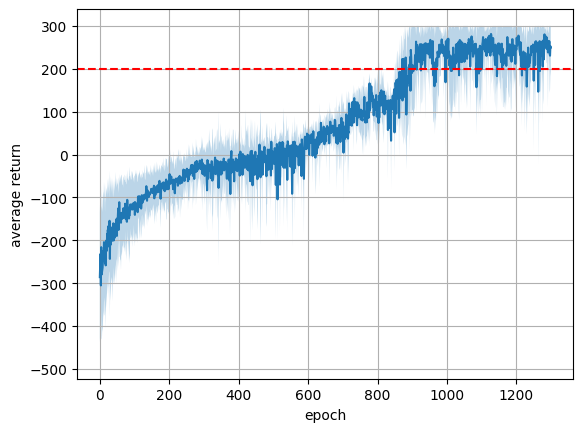

In [15]:
"""
Now you'll put everything together to train your REINFORCE agent!

Fill in the TODOs below to:
1. Set up the environment
2. Create the policy network
3. Create the optimizer
4. Run the training loop
5. Plot the results

This is the complete pipeline you'll use for experimentation in Exercise 4.
"""

# Hyperparameters
env_name = "LunarLander-v3"
hidden_sizes = [64, 64]
lr = 3e-4
epochs = 1300  # You can increase this for better results
batch_size = 5000
gamma = 0.99
plot = True

# TODO 1: Create the environment
# Hint: Use gym.make() with continuous=Truebatch_rewards for LunarLander-v3
env = gym.make(env_name, continuous=True)

# TODO 2: Get observation and action dimensions from the environment
# Hint: Use env.observation_batch_rewardsspace.shape[0] and env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]
n_acts = env.action_space.shape[0]

# TODO 3: Create the policy network using mlp()
# Hint: Input size is obs_dim, output size is 2*n_acts (for mean and logstd)

# NOTE: this is the architecture of the neural network, obs as input, hidden layers and 2*acts as output
policy_net = mlp([obs_dim, *hidden_sizes, 2*n_acts])

# TODO 4: Create the optimizer
# Hint: Use Adam optimizer with the policy network parameters and learning rate
optimizer = Adam(policy_net.parameters(), lr=lr)

# Initialize tracking
returns = []
std = []

# TODO 5: Create a training loop that runs for 'epochs' iterations
# Hint: Use tqdm(range(1, epochs+1)) for a progress bar
# For each epoch:
#   - Call train_one_epoch() to get batch_rets and batch_lens
#   - Compute average return and episode length
#   - Append to returns list
#   - Append std of batch_rets to stds list
#   - Update progress bar with avg_ret and avg_len

# YOUR CODE HERE for the training loop
progress_bar = tqdm(range(1, epochs+1))
for _ in progress_bar:
  batch_rewards, batch_lengths = train_one_epoch()
  avg_ret, avg_len = np.mean(batch_rewards), np.mean(batch_lengths)
  returns.append(avg_ret)

  std_ret = np.std(batch_rewards)
  std.append(std_ret)

  progress_bar.set_postfix({'avg _ret': f'{avg_ret:5.0f}', "avg_len": f"{avg_len:5.0f}"})


if plot:
  plt.plot(returns)
  plt.fill_between(range(len(returns)), np.array(returns) - np.array(std), np.minimum(300, np.array(returns) + np.array(std)), alpha=0.3)
  plt.grid()
  goal = {"LunarLander-v3": 200, "BipedalWalker-v3": 300}.get(env_name, 0)
  plt.axhline(goal, color='r', linestyle='--')
  plt.xlabel('epoch')
  plt.ylabel('average return')
  timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
  plt.savefig(f"Reinforce_training_{timestamp}.png")
  plt.show()

# EXERCISE 4: Experimentation

Try running REINFORCE on different environments and with different hyperparameters.

To learn more about the specific enviroments, visit [Gymnasium](https://gymnasium.farama.org/).

## Suggested Experiments:

### 1. Different Environments:

**CartPole-v1** (Easy, fast learning ~100 epochs):
- Change env_name to "CartPole-v1"
- Note: CartPole has DISCRETE actions, so you'll need to modify the structure of the policy network and the functions get_policy and get_action
  - Remember how the output layer should look like if we want a stochastic policy for discrete actions?
- Or skip this and stick with continuous control tasks

**LunarLander-v3** (Medium difficulty):
- Goal: 200+ average return
- Typical training: 500-800 epochs
- Good for testing different hyperparameters

**BipedalWalker-v3** (Hard, slow learning):
- Change env_name to "BipedalWalker-v3" (The continuous parameter is not available here)
- Goal: 300+ average return
- Needs 800-1000+ epochs
- Very sensitive to hyperparameters
- Great for seeing the effect of batch_size and lr

### 2. Hyperparameter Exploration:

Try varying:
- **Learning rate (lr)**
  - Too high: Unstable learning, policy might collapse
  - Too low: Very slow learning
  
- **Batch size**
  - Larger: More stable gradients but slower epochs
  - Smaller: Faster epochs but noisier gradients
  
- **Hidden layer sizes**
  - Bigger networks: More capacity but slower training
  
- **Discount factor (gamma)**
  - Higher gamma: Agent plans further ahead
  - Lower gamma: More short-sighted behavior

### 3. Things to Observe:

- How does the learning curve change?
- Does the agent solve the task?
- How stable is training?

### Tips:
- Start with LunarLander-v3 (it trains in reasonable time)
- Make ONE change at a time to see its effect
- Keep notes on what works and what doesn't
- Compare learning curves side-by-side

**To experiment:** Simply modify the hyperparameters in Exercise 3 and re-run!